In [17]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [8]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [9]:
import torch
torch.cuda.is_available()

True

# Preprocessing

In [18]:
labels = pd.read_csv("../Datasets/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
labels.sample(10)

,patientId,x,y,width,height,Target
16762,a184416c-bf22-4b8c-902e-c162f13e724a,NaN,NaN,NaN,NaN,0
5005,434dc670-8986-4ce3-91b7-e9d6e0e97103,NaN,NaN,NaN,NaN,0
23353,d24470a3-90c7-4640-8e60-1aa394c2f929,NaN,NaN,NaN,NaN,0
21074,bf27db61-1c2e-4710-9f25-31eacb526f5e,165.0,714.0,221.0,269.0,1
25487,e45651e0-05ab-4d25-b876-cb84ec5af1aa,NaN,NaN,NaN,NaN,0
26642,ed38283d-165f-481b-bbb3-5532450b82c1,599.0,220.0,167.0,185.0,1
20896,be0d1645-263c-4dce-99e9-77f31d6ded61,193.0,192.0,238.0,639.0,1
24087,d88c71a0-73f2-4fdc-b870-38a3bf4c2a2d,NaN,NaN,NaN,NaN,0
19145,b29dcdc8-57c8-443a-a69c-615fa7dc9973,174.0,592.0,220.0,130.0,1
27972,f8093df6-3bbe-4a3a-8cfd-31732ef99aca,NaN,NaN,NaN,NaN,0


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [19]:
labels = labels.drop_duplicates("patientId")
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  26684 non-null  object 
 1   x          6012 non-null   float64
 2   y          6012 non-null   float64
 3   width      6012 non-null   float64
 4   height     6012 non-null   float64
 5   Target     26684 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [20]:
ROOT_PATH = Path("../Datasets/rsna-pneumonia-detection-challenge/stage_2_train_images/")
SAVE_PATH = Path("../Datasets/Processed/")

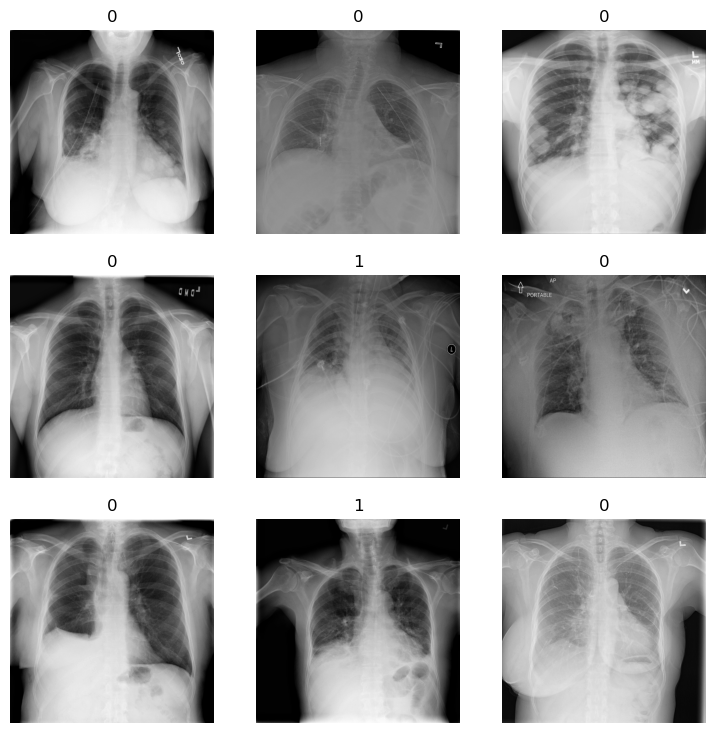

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
c = 0
for i in range(3):
    for j in range(3):
        pt_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/pt_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]
        
        axs[i][j].imshow(dcm, cmap='gray')
        axs[i][j].set_title(label)
        axs[i][j].axis('off')
        c += 1

In [19]:
sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    
    dcm = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    label = labels.Target.iloc[c]
    
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm)
    
    normalizer = dcm.shape[0] * dcm.shape[1]
    if train_or_val == 'train':
        sums += np.sum(dcm) / normalizer
        sums_squared += np.power(dcm, 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [21]:
mean = sums / 24000
std = np.sqrt(sums_squared / 2400 - (mean**2))

NameError: name 'sums' is not defined

In [21]:
print(f"The mean is {mean} and std is {std}")

The mean is 0.4903962485384803 and std is 1.667090835251211


In [22]:
mean = 0.4903962485384803
std = 1.667090835251211

# Training

In [23]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [24]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomAffine(
        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)
    ),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [25]:
train_dataset = torchvision.datasets.DatasetFolder(
    "../Datasets/Processed/train",
    loader=load_file, extensions='npy', transform=train_transforms
)

val_dataset = torchvision.datasets.DatasetFolder(
    "../Datasets/Processed/val",
    loader=load_file, extensions='npy', transform=val_transforms
)

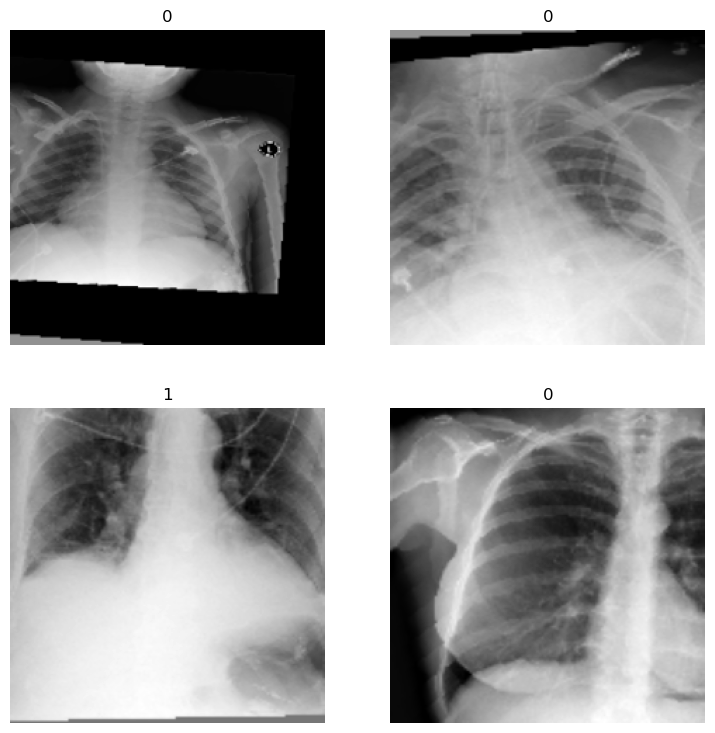

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_idx = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_idx]
        
        axs[i][j].imshow(x_ray[0], cmap='gray')
        axs[i][j].set_title(label)
        axs[i][j].axis('off')

In [73]:
batch_size = 4
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"Train: {len(train_loader)} and Val: {len(val_loader)}")

Train: 6000 and Val: 671


In [32]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

In [33]:
np.unique(val_dataset.targets, return_counts=True)

(array([0, 1]), array([2079,  605]))

In [91]:
class PneumeniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        self.train_acc = torchmetrics.Accuracy('binary')
        self.val_acc = torchmetrics.Accuracy('binary')
        
#         self.validation_step_outputs = []
        
        
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self.model(x_ray)[:, 0]
        loss = self.loss_fn(pred, label)
        
        self.log("Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def on_train_epoch_end(self, outs):
        self.log("Train Acc", self.train_acc.compute())
    
    def validation_step(self, batch, batch_idx):
            x_ray, label = batch
            label = label.float()
            pred = self.model(x_ray)[:, 0]
            loss = self.loss_fn(pred, label)

            self.log("Val Loss", loss)
            self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
#             self.validation_step_outputs.append(loss)
            return loss
    
    def on_validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
        
        
    def configure_optimizers(self):
        return [self.optimizer]

In [92]:
model = PneumeniaModel()

In [93]:
checkpoint_callback = ModelCheckpoint(
    monitor="Val Acc",
    save_top_k=2,
    mode='max'
)

In [94]:
trainer = pl.Trainer(logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                    callbacks=checkpoint_callback, max_epochs=2)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [95]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

TypeError: on_train_epoch_end() missing 1 required positional argument: 'outs'